<a href="https://colab.research.google.com/github/ccrosby96/Music-Genre-Classifier/blob/main/Group1_Final_Project_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Final Project Group 1: Music genre Classification**

##### Group Members: Mary Dao, Calvin Crosby, Joshua Epstein, Maya Webb

---



## Libraries

In [ ]:
# make sure to install any Libraries you may not have 
# ones you may need to install transformers, torch, and tensorflow 
!pip install transformers

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout,Dense
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import re
import math
import sys
import random
import pickle 

# from IPython.lib.display import join
# from tqdm.notebook import tqdm
from collections import Counter
from timeit import default_timer as timer

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import f1_score

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 28.3 MB/s 
     |████████████████████████████████| 182 kB 75.3 MB/s 
     |████████████████████████████████| 7.6 MB 71.8 MB/s 


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Mounted at /content/drive


## Import Data 

In [ ]:
# import the data make sure to change the file path if you have
# saved them somwhere else

# df_train = pd.read_csv("/content/drive/My Drive/NLP/train.csv")
# df_test = pd.read_csv("/content/drive/My Drive/NLP/val.csv")
# country_csv = pd.read_csv("/content/drive/My Drive/NLP/country_data.csv").dropna()

df_train = pd.read_csv("/content/drive/My Drive/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/val.csv")
country_csv = pd.read_csv("/content/drive/My Drive/country_data_v5.csv").dropna()

# df_train = pd.read_csv("/content/drive/MyDrive/CS_6120_Final_Project/Items_turning In/Data/group1_training.csv")
# df_test = pd.read_csv("/content/drive/MyDrive/CS_6120_Final_Project/Items_turning In/Data/group1_testing.csv")
# country_csv = pd.read_csv("/content/drive/MyDrive/CS_6120_Final_Project/Items_turning In/Data/group1_country_data.csv").dropna()

In [ ]:
# add the country data into the overall dataframe for training
country_train = country_csv[:4000]
country_df = country_csv[['Lyric', "Genre0"]]
df_train = pd.concat([df_train, country_train])
print(df_train.head())
print(df_train.shape)

                                               Lyric   Genre0 Title
0  [Intro: Method Man w/ sample] + (Sunny valenti...  Hip Hop   NaN
1  [Sean Paul:]. Aye. It's Sean Paul 'long side. ...      Pop   NaN
2  Beauty finds refuge in herself. Lovers wrapped...    Indie   NaN
3  You've changed your tune. many times since we'...     Rock   NaN
4  I got all these J's rolled up. And got all the...  Hip Hop   NaN
(52493, 3)


In [ ]:
# add the country data into the overall dataframe for testing
country_test =  country_csv[4000:]
df_test = pd.concat([df_test, country_test])
print(df_test.head())
print(df_test.shape)

                                               Lyric       Genre0 Title
0  I was nineteen when I came to town they called...         Rock   NaN
1  Your coat and hat are gone. I've really can't ...         Rock   NaN
2  Use my Body to keep you with mine. Yeah I'm on...      Hip Hop   NaN
3  I met her at the 'Burger King'. We fell in lov...         Rock   NaN
4  This is the end of everything. A degenerate cu...  Heavy Metal   NaN
(8216, 3)


## Helper Methods

#### Clean Data

In [ ]:
# Clean the text
def clean_text(text):
    '''
    Arguments:
    text : a string that you want to clean

    Returns:
    The cleaned version of the string 
    '''
    text = text.lower()
    text_punc_gone = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_punc_gone)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

#### Train Test split Helper

In [ ]:
# splits our training and testing data X_train, X_test  , y_train, y_test
# by the given genres 
def test_train_split(df_train, df_test, genres):
  '''
  Arguments:
  df_train : The training data that is being editited 
  df_test : The testing data that is being editited 
  genres : The list of genres that we want to consider if the list is empty
  consider all the genres 

  Returns:
  X_train, X_test  , y_train, y_test split of the training and testing data
  the lyric and genre splits 

  '''
  if len(genres) == 0:
    X_train = df_train.loc[:, 'Lyric']
    X_test = df_test.loc[:, 'Lyric']

    y_train = df_train.loc[:, 'Genre0']
    y_test = df_test.loc[:, 'Genre0']
  else:
    df_train = df_train.loc[df_train['Genre0'].isin(genres),:]
    df_test = df_test.loc[df_test['Genre0'].isin(genres),:]

    X_train = df_train.loc[:, 'Lyric']  
    X_test = df_test.loc[:, 'Lyric']

    y_train = df_train.loc[:, 'Genre0']
    y_test = df_test.loc[:, 'Genre0']

    return X_train, X_test, y_train, y_test                   


### Vocabulary Update Method

In [ ]:
def update_vocab(vocab, words):
    '''
    Updates the word vocab count for the given sent of words in the given dictionary 

    Arguments:

    vocab : The dictionary that is being updated 

    words : The list of words we are iterating through to update their counts

    '''
    for w in words:
        vocab[w] = 1 + vocab.get(w,0)

In [ ]:
# make a copy of our data set so we don't effect other cells that need this data
all_data = df_train.copy()
all_data['Lyric'] = all_data['Lyric'].apply(clean_text)

In [ ]:
# set up the dictionaries 
hip_hop_vocab = {}
pop_vocab = {}
rock_vocab = {}
country_vocab = {}

In [ ]:
# loop through all the rows in our data and split the lyric for the given row
# Then run the update vocab depending on the genre 
for index, row in all_data.iterrows():
    words = row['Lyric'].split()
    g = row['Genre0']
    if g == "Country":
        update_vocab(country_vocab, words)
    elif g == "Hip Hop":
        update_vocab(hip_hop_vocab, words)
    elif g == "Pop":
        update_vocab(pop_vocab, words)
    else:
        update_vocab(rock_vocab, words)

# Sort out our vocab from greatest to least
hip_hop_tupes = sorted(hip_hop_vocab.items(), key = lambda x : x[1], reverse = True)
pop_tupes = sorted(pop_vocab.items(), key = lambda x : x[1], reverse = True)
rock_tupes = sorted(rock_vocab.items(), key = lambda x : x[1], reverse = True)
country_tupes = sorted(country_vocab.items(), key = lambda x : x[1], reverse = True)

# only look at top 300
hip_hop_tupes = hip_hop_tupes[:300]
hip_hop_top_set = set([t[0] for t in hip_hop_tupes])

pop_tupes = pop_tupes[:300]
pop_top_set = set([t[0] for t in pop_tupes])

rock_tupes = rock_tupes[:300]
rock_top_set = set([t[0] for t in rock_tupes])

country_tupes = country_tupes[:300]
country_top_set = set([t[0] for t in country_tupes])

In [ ]:
# set up lists then only build lists and only consisder top 10 now for graphing
# sake
hip_hop_words = []
country_words = []
rock_words = []
pop_words = []

num_words = 10
for t in hip_hop_tupes:
    if len(hip_hop_words) == num_words:
        break
    word = t[0]

    if word not in country_top_set and word not in rock_top_set and word not in pop_top_set:
        hip_hop_words.append(t)
    
for t in country_tupes:
    if len(country_words) == num_words:
        break
    word = t[0]
    if word not in hip_hop_top_set and word not in rock_top_set and word not in pop_top_set:
        country_words.append(t)
   
for t in pop_tupes:
    if len(pop_words) == num_words:
        break
    word = t[0]
    if word not in country_top_set and word not in hip_hop_top_set and word not in rock_top_set:
        pop_words.append(t)

for t in rock_tupes:
    if len(rock_words) == num_words:
        break
    word = t[0]
    if word not in country_top_set and word not in pop_top_set and word not in hip_hop_top_set:
        rock_words.append(t)

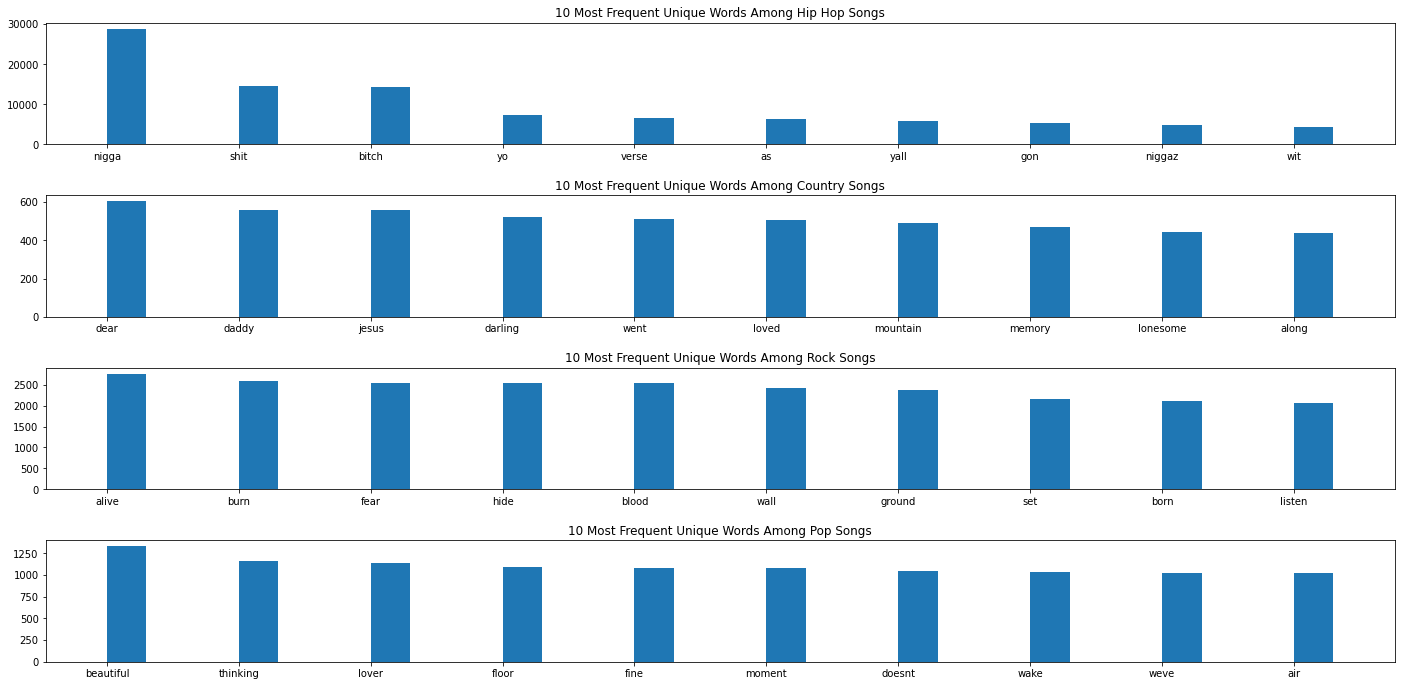

In [ ]:
# graph our top 10 words in each using a bar graph set up
fig, axes = plt.subplots(4,1, figsize=(20,10))
fig.tight_layout(pad = 3.0)
axes[0].bar([t[0] for t in hip_hop_words], [t[1] for t in hip_hop_words], align='edge',width=0.3)
axes[0].title.set_text(f"{len(hip_hop_words)} Most Frequent Unique Words Among Hip Hop Songs")
axes[1].bar([t[0] for t in country_words], [t[1] for t in country_words], align='edge',width=0.3)
axes[1].title.set_text(f"{len(country_words)} Most Frequent Unique Words Among Country Songs")
axes[2].bar([t[0] for t in rock_words], [t[1] for t in rock_words], align = 'edge', width = 0.3)
axes[2].title.set_text(f"{len(rock_words)} Most Frequent Unique Words Among Rock Songs")
axes[3].bar([t[0] for t in pop_words], [t[1] for t in pop_words], align = 'edge', width = 0.3)
axes[3].title.set_text(f"{len(pop_words)} Most Frequent Unique Words Among Pop Songs")

## TSNE Genre Identifier

#### Build Training and Testing Data

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


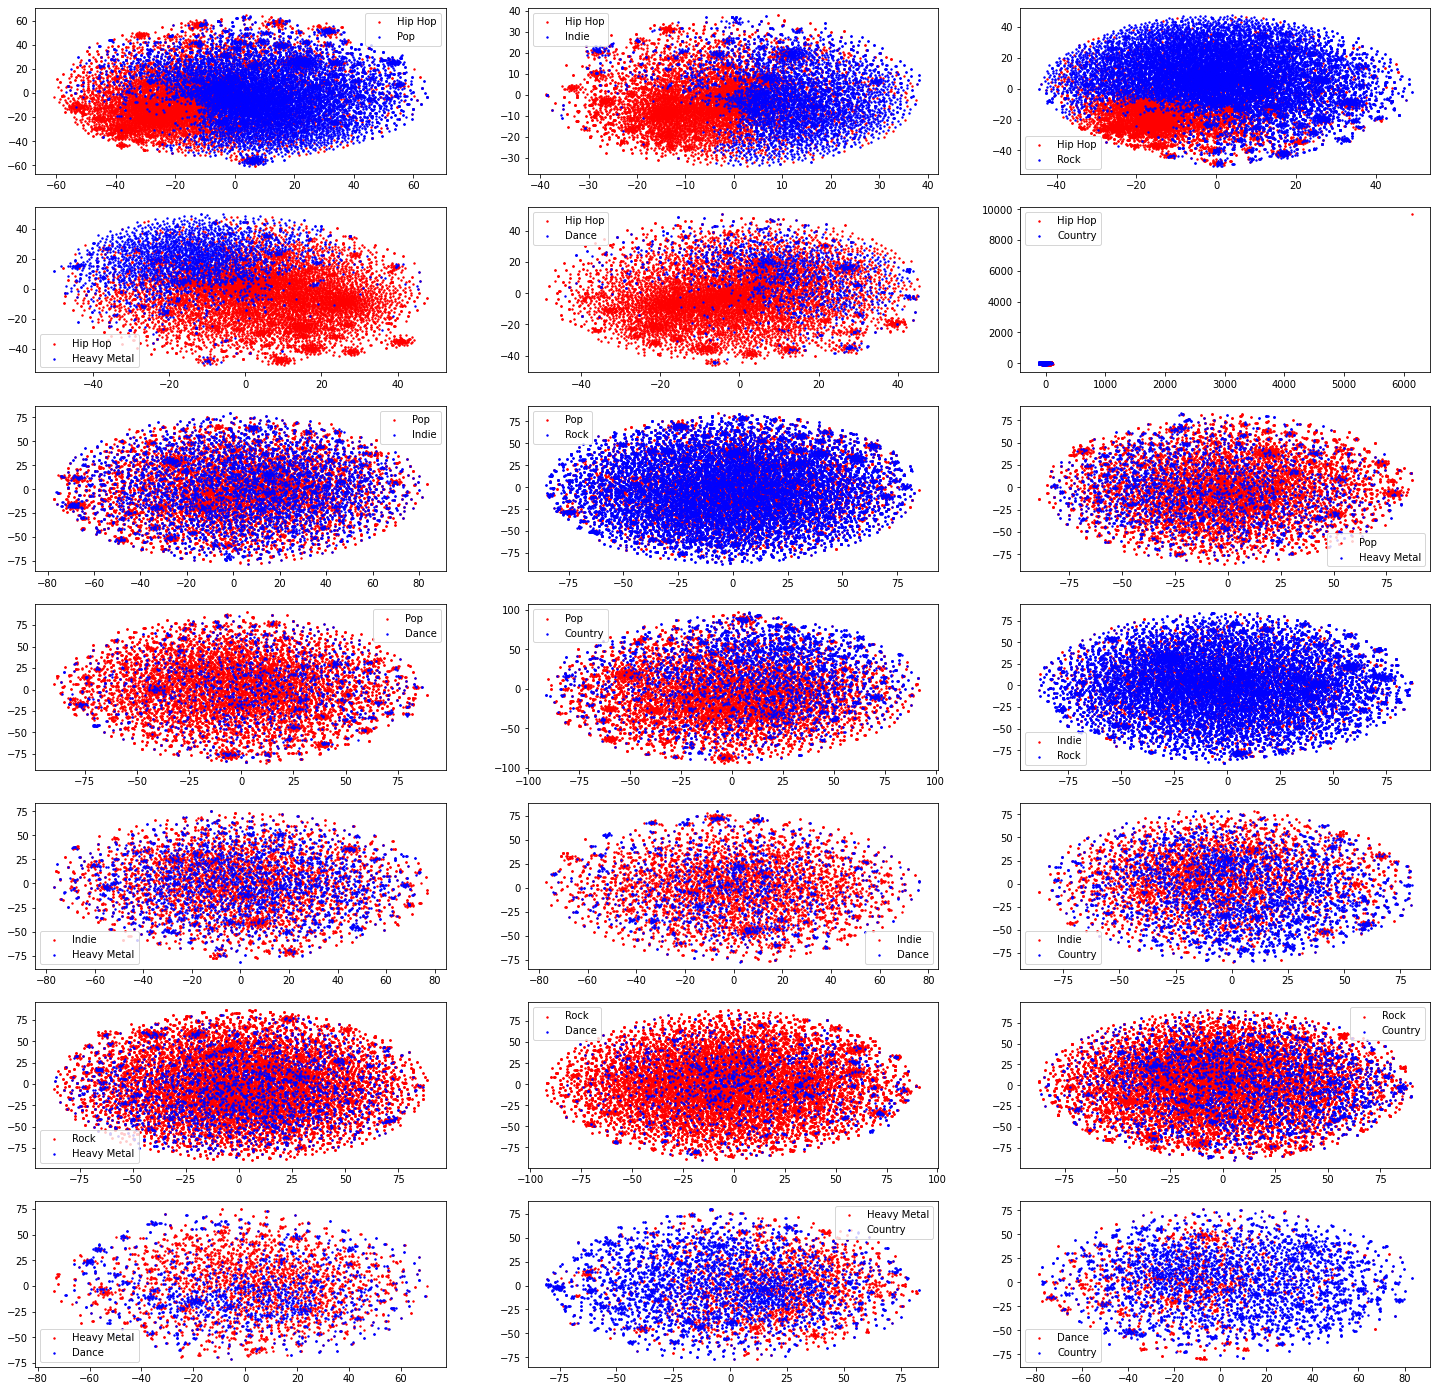

In [ ]:
# this is set up so we loop through each of the possible genre and build up all the
# possible pairs we could have to run our TSNE to find out the most different Genres
# Along with this we will graph the pairings 
genres = ["Hip Hop", "Pop", "Indie", "Rock", "Heavy Metal", "Dance", "Country"]
genre_pairs = [[a, b] for idx, a in enumerate(genres) for b in genres[idx + 1:]]
fig, ax = plt.subplots(7, 3, figsize=(25,25))
ax = ax.ravel()
for idx, pair in enumerate(genre_pairs):
  X_train, X_test, y_train, y_test = test_train_split(df_train, df_test, pair)
  X_train = X_train.apply(clean_text)
  X_test = X_test.apply(clean_text)

  vectorizer = TfidfVectorizer()
  X_train = vectorizer.fit_transform(X_train)
  tsne = TSNE(n_components=2)
  X_train_tsne = tsne.fit_transform(X_train)

  genres = np.unique(y_train)
  X_train_tsne = np.hstack((X_train_tsne, np.array(y_train).reshape(-1,1)))

  colors = ['red', 'blue']
  for index, genre in enumerate(pair):
    X_genre = X_train_tsne[np.where(X_train_tsne[:,2]==genre)]
    ax[idx].scatter(X_genre[:,0].astype(float), X_genre[:,1].astype(float), 2, color=colors[index], label=genre)
  ax[idx].legend()
plt.show()

## Multinomial Naive-Bayes

#### Build Training and Testing Data

In [ ]:
# List of possible genres you can have in the MNNB
# ["Hip Hop", "Pop", "Indie", "Rock", "Heavy Metal", "Dance", "Country"]
# In gerneral we found these the 3 genres to be the most different when it
# comes to identifying them  
genres = ["Hip Hop", "Pop", "Indie", "Rock", "Heavy Metal", "Dance", "Country"]
# genres = ["Hip Hop", "Country", "Pop", "Rock"]
# train test split and clean data
X_train, X_test, y_train, y_test = test_train_split(df_train, df_test, genres)
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

#### Vectorize our Training Data With TFIDF

In [ ]:
# TFIDF vectorizing of the data 
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
# label encoder 
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Run Multinomial Naive-Bayes

In [ ]:
# use MNB to fit the data 
classifier = MultinomialNB(alpha=0.01)
classifier.fit(X_train, y_train)

train_pred = classifier.predict(X_train)
test_pred = classifier.predict(X_test)

##### Accuracy and F1 Score

In [ ]:
# get the F1 score and accuracy of the training and testing data 
train_f1 = metrics.f1_score(y_train, train_pred, average='weighted')
train_acc = metrics.accuracy_score(y_train, train_pred)

print("Training F1 Score: ", train_f1)
print("Training Accuracy: ", train_acc)

print()

test_f1 = metrics.f1_score(y_test, test_pred, average='weighted')
test_acc = metrics.accuracy_score(y_test, test_pred)

print("Testing F1 Score: ", test_f1)
print("Testing Accuracy: ", test_acc)

Training F1 Score:  0.7406585949055683
Training Accuracy:  0.7520431295601319

Testing F1 Score:  0.4194102798579765
Testing Accuracy:  0.46226874391431355


In [ ]:
for g in np.unique(y_test):
  true = y_test[np.where(y_test==g)]
  pred = test_pred[np.where(y_test==g)]
  print(le.inverse_transform([g])[0])
  print(metrics.accuracy_score(true, pred), '\n')

Country
0.2207286876547577 

Dance
0.0898876404494382 

Heavy Metal
0.04697986577181208 

Hip Hop
0.8195020746887967 

Indie
0.04873949579831933 

Pop
0.4340836012861736 

Rock
0.8459715639810427 



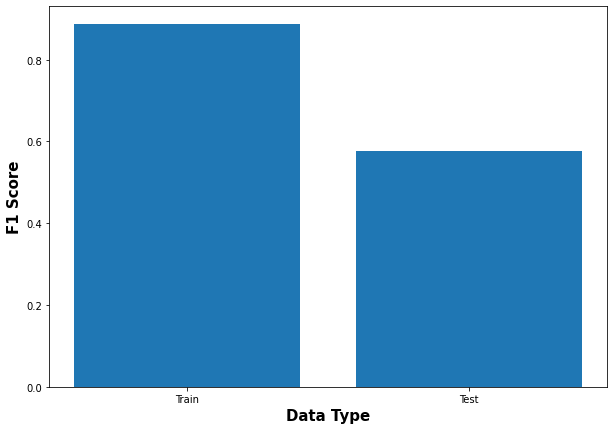

In [ ]:
# compare the F1 scores of the training and testing data 
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
f1_score = [train_f1, test_f1]
name = ["Train", "Test"]
plt.bar(name, f1_score)
plt.xlabel('Data Type', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score', fontweight ='bold', fontsize = 15)
 
# Show Plot
plt.show()

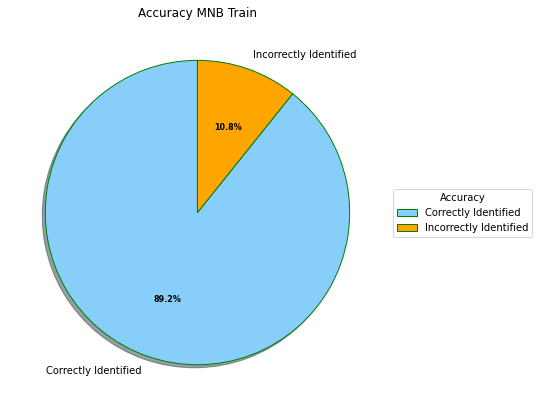

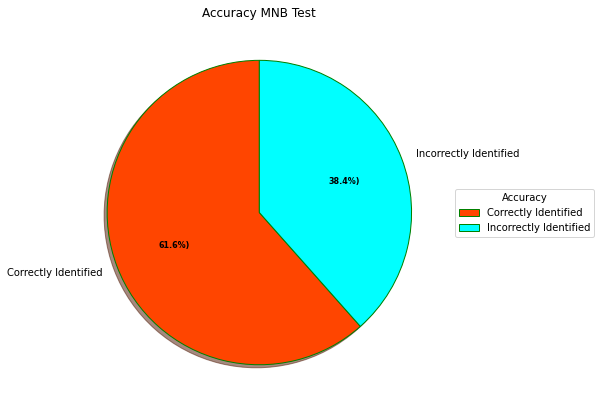

In [ ]:
# graphing the accuracy of each one
# Creating dataset
pie_vals = ['Correctly Identified', 'Incorrectly Identified']
train_data = [train_acc, 1 - train_acc]


 
# Creating color parameters
colors = ( "lightskyblue", "Orange")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(train_data,
                                  autopct = lambda pct: func(pct, train_data),
                                  labels = pie_vals,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="Black"))
 
# Adding legend
ax.legend(wedges, pie_vals,
          title ="Accuracy",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Accuracy MNB Train")
 
# show plot
plt.show()


###############################

# Creating dataset
test_data = [test_acc, 1 - test_acc]
 
 
 
# Creating color parameters
colors = ( "orangered", "cyan")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%)".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(test_data,
                                  autopct = lambda pct: func(pct, test_data),
                                  labels = pie_vals,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="Black"))
 
# Adding legend
ax.legend(wedges, pie_vals,
          title ="Accuracy",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Accuracy MNB Test")
 
# show plot
plt.show()

## BERT Neural Network

### Data Loading and Encoding

In [ ]:
# read and preprocess data
path = '/content/drive/My Drive/'

country = pd.read_csv(path+'country_data_v5.csv', usecols=['Lyric', 'Genre0']).dropna()

country_train = country.iloc[:len(country)*8//10,:].copy()
country_test = country.iloc[len(country)*8//10:,:].copy()

df = pd.read_csv(path+'train.csv')
df = pd.concat([df, country_train], ignore_index=True)

# only using these 4 genres
df = df.loc[df['Genre0'].isin(['Pop','Country', 'Rock', 'Hip Hop']), :]

# downsample rock and pop so training data is more evenly spread
for g in ['Rock', 'Pop']:
  mask = (df['Genre0'] == g)
  idx = mask.loc[mask==True]
  
  to_drop = list(idx.index)[:len(idx)//2]
  df = df.drop(index=to_drop)

df.reset_index(inplace=True)

df_test = pd.read_csv(path+'val.csv')
df_test = pd.concat([df_test, country_test], ignore_index=True)
df_test = df_test.loc[df_test['Genre0'].isin(['Pop','Country', 'Rock', 'Hip Hop']), :]

# mapping string genres to integer labels
possible_labels = df.Genre0.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

df['label'] = df.Genre0.replace(label_dict)
df_test['label'] = df_test.Genre0.replace(label_dict)

In [ ]:
from sklearn.model_selection import train_test_split

# divide training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.10, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

# specify set type for easy indexing
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# tokenize training and validation data
encoded_data_train = tokenizer(
    df.loc[df.data_type=='train','Lyric'].tolist(),
    return_attention_mask=True, 
    padding=True,
    truncation=True,
    max_length=512, 
    return_tensors='pt'
)

encoded_data_val = tokenizer(
    df.loc[df.data_type=='val','Lyric'].tolist(),
    return_attention_mask=True, 
    padding=True,
    truncation=True,
    max_length=512, 
    return_tensors='pt'
)

# preparing data from tokenizer output
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

# creating Dataset objects from tokenized/encoded data
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# check dataset sizes
print(len(dataset_train), len(dataset_val))

# creating Dataloader objects for model training and evaluation
BATCH_SIZE = 12

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=BATCH_SIZE)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=BATCH_SIZE)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

26493 2944


In [ ]:
# define functions to compute evaluation metrics
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
# setting seed values for reproducibility
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# define model and hyperparameters
# num_training_steps=(NUM_EPOCHS * len(dataloader_train))//BATCH_SIZE
LEARNING_RATE = 1e-5
NUM_EPOCHS = 10

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=LEARNING_RATE)

# use GPU if available for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

### Training the network

In [ ]:
# define train and validation functions
def train_epoch(model, optimizer, train_dataloader):
    model.train()
    losses = 0
    
    train_item_counter = 0
    for batch in train_dataloader:
      batch = tuple(b.to(device) for b in batch)
        
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'labels':         batch[2],
                }       

      outputs = model(**inputs)
      
      optimizer.zero_grad()

      loss = outputs.loss
      losses += loss.item()
      loss.backward()

      optimizer.step()
      train_item_counter += 1

    train_loss = losses/train_item_counter

    return train_loss


def evaluate(model, val_dataloader):
    model.eval()
    losses = 0
    predictions, true_vals = [], []

    val_item_counter = 0
    for batch in val_dataloader:
      batch = tuple(b.to(device) for b in batch)
        
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'labels':         batch[2],
                }     

      with torch.no_grad():        
        outputs = model(**inputs)
          
      loss = outputs.loss
      losses += loss.item()
      
      logits = outputs.logits
      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      
      predictions.append(logits)
      true_vals.append(label_ids)

      val_item_counter += 1

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    
    val_loss = losses/val_item_counter            
    
    return val_loss, predictions, true_vals


# train the model for number of epochs specified
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, dataloader_train)
    end_time = timer()

    torch.save(model.state_dict(), f'{path}genre_models/BERT_epoch_{epoch}.model')

    val_loss, predictions, true_vals = evaluate(model, dataloader_validation)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
    val_f1 = f1_score_func(predictions, true_vals)
    print(f'\nF1 Score (Weighted): {val_f1}\n')
    
    accuracy_per_class(predictions, true_vals)
    print()

### Test Set Predictions

In [ ]:
path = '/content/drive/My Drive/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

BATCH_SIZE = 12

# load the trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load(f'{path}genre_models/BERT_final_epoch_2.model', map_location=torch.device(device)))

# encode/tokenize the validation data
encoded_data_test = tokenizer(
    df_test.loc[:,'Lyric'].tolist(),
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=512, 
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
dataset_test = TensorDataset(input_ids_test, attention_masks_test)

# generate dataloader object
dataloader_test = DataLoader(dataset_test,
                             sampler=SequentialSampler(dataset_test),
                             batch_size=BATCH_SIZE)

# run the model on validation data
model.eval()

pred_label=[]
for batch in dataloader_test:
  batch = tuple(b.to(device) for b in batch)
  
  inputs = {'input_ids': batch[0],
            'attention_mask': batch[1],
            }

  with torch.no_grad():
    outputs = model(**inputs)
  
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  pred_label.extend(logits.argmax(axis=1))

df_test['pred_label'] = pred_label

# print accuracy results by genre
label_dict_inverse = {v: k for k, v in label_dict.items()}
for label in np.unique(df_test['label']):
    y_preds = df_test['pred_label'][df_test['label']==label]
    y_true = df_test['label'][df_test['label']==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Hip Hop
Accuracy: 843/964

Class: Pop
Accuracy: 650/1244

Class: Rock
Accuracy: 1852/2110

Class: Country
Accuracy: 1365/1366



## N-Gram Song Generator

#### Train Build N_gram

In [ ]:
# similar to the homework set up possible n_gram info to build the sentences
# for the n_gram we will attach a header and tail to each sentence so the are
# formatted as necessary 

UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"
n_gram = 15
is_laplace_smoothing = True
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = None
threshold = 5
HEADER = "<s> " * (n_gram - 1)
TAIL = " </s>" * (n_gram - 1)


In [ ]:
def make_ngrams(tokens: list, n: int) -> list:
    '''
    Arguments:
    tokens : A list of words that will be split into our N_grams  
    n : The size of the n_gram splits
    Returns:
    A list of the ngram splits 
    '''
    n_grams = []
    index = 0
    # loop through till you hit our list end for building the n-grams 
    while index < len(tokens)+1-n:
        n_grams.append(tokens[index: index + n])
        index += 1
    return n_grams

In [ ]:
def train(content):
    '''
    Arguments:
    content : A list of our lyrics that we will be looping through
    Returns:
    returns a dictionary that contains the counts of each n_gram and a dictionary
    of the count of each n_gram of size n - 1 , a list of the vocab we have
    and the content that was orginally passed as well 
    '''
    # Go through and get the counts of each word in the dictionary 
    word_counts = dict()
    for word in content:
        if word not in word_counts:
            word_counts[word] = 1
        else:
            word_counts[word] += 1 
    # any word that does not appear more that the threshold replace it with UNK
    # threshold is set to 5 so we only condier words taht are very common in
    # a given genre 
    vocab = set()
    for word in word_counts:
        if word_counts[word] <= threshold:
            index = content.index(word)
            content[index] = UNK
        else:
            vocab.add(word)
    
    # make use of make_n_grams function
    # and build our n_gram counts of size n 
    n_gram_counts = dict()
    for item in make_ngrams(content, n_gram): 
        if tuple(item) not in n_gram_counts:
            n_gram_counts[tuple(item)] = 1
        else: 
            n_gram_counts[tuple(item)] += 1
            
            
    # For n>1 grams compute n-1 gram counts to compute probability    
    n_minus_1_gram_counts = dict()
    if n_gram > 1:
        for item in make_ngrams(content, n_gram - 1): 
            if tuple(item) not in n_minus_1_gram_counts:
                n_minus_1_gram_counts[tuple(item)] = 1
            else: 
                n_minus_1_gram_counts[tuple(item)] += 1
                
    vocab1 = list(content)
    return n_gram_counts, vocab, n_minus_1_gram_counts, vocab1

In [ ]:
# this will go through our training and testing data for the N_gram and 
# build up a list for the sentences that appear in each song and attaches our
# header and tail to the senteces so it can actually be in teh correct N_gram 
# format also gets rid of repeated sentences so certain phases that may appear 
# many times in one song are taken care of 
def build_ngram_train():
  '''
  Returns:
  A string that is representitive
  of the training data 
  '''
  corpus_train = set()
  for item in X_Gram_train[:400]:
    split = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', item)
    for i in range(len(split)):
      split[i] = split[i][0:len(split[i]) - 1].lower()
      corpus_train.add(HEADER + split[i] + TAIL)
  train_strings = list(corpus_train)
  train_string = ' '.join(train_strings)
  return train_string

In [ ]:
# builds our trainig testinf and N-gram values 
n_gram_train = df_train.loc[df_train['Genre0'].isin(["Rock"]),:]
X_Gram_train = n_gram_train.loc[:, 'Lyric']  


content_train = build_ngram_train()
content = content_train.split()
n_gram_counts, vocab, n_minus_1_gram_counts, vocab1 = train(content)

print(len(n_gram_counts))
print(len(vocab))

163363
1090


#### Generate Songs

In [ ]:
def generate_songs():
    """ Generates a single song from a trained language 
            model using the Shannon technique.
    Returns:
      str: the generated song
    """
    song = [SENT_BEGIN]
    prev_word = SENT_BEGIN
    if n_gram > 2:
        song +=  [SENT_BEGIN] * (n_gram - 2)   
    index = 0
    while prev_word != SENT_END:
        curr_n_minus_1 = song[index:index + n_gram - 1]
        probs = []
        for word in vocab:
            curr_n_gram = tuple(curr_n_minus_1 + [word])
            count = 0
            for key, val in n_gram_counts.items():
                if key == curr_n_gram:
                    count += val
            probs.append(count + .01 / (sum(n_gram_counts.values())))
        probs = np.array(probs)
        probs /= probs.sum()
        word = np.random.choice(list(vocab), p=probs)
        if word != '<s>':
          if index == 100:
            prev_word = SENT_END
            song.append(SENT_END)
            index += 1
          else:
            prev_word = word
            song.append(word)
            index += 1            
                
    if n_gram > 2:
        song +=  [SENT_END] * (n_gram - 2)
                            
    senteces = " ".join(song)
    return senteces

In [ ]:
song = generate_songs()
print(song)

<s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> i don't want the against here better love do making perfect ho ? do? treat says hangin' mouth hands tree bound why tree climb moon forever cocaine angel has don’t forever divided breathe does me ending most chains perfect year throw water round red dead very together fade dance across tonight sing set hair go. skin his making we've golden places brand west those can’t watching dance wanted across put highway smile if me. look lost waste tune king thinking scream - yours breath face since sit winter feeling send buried sweet might sign everybody too past f# just power </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


##### Generated Songs

Country Song:
chicken in black for the god that the good times i got the bull of the four thoughts her singing thousand open send ya mister death until high's living way looked you'll refuse gang mine ringing lose shine comes music wanted sure someone rich clock shoot sadness won't meant then two before fell heartache must listenin' prayed police flag ben coal stray we're love wicked brings fill sympathy wall quit past town ira written everything man far lord brother lookin' johnny we'll worth close hand different fighting till luck everybody carpenter blow beat steel something carry shed gang ya an


Country Song: you said one love one life when it's one need in the night one love we get to share it it leaves you baby if you don't care for it did i guess each gold waiting would room gun drinking week sunshine broken pictures he goodin ten fever talk turn further willow holding bells sleep face time shines leaves side within asked crazy sure blues nashville all strange there's dreaming hey goodin sad little anything another sight fall texas leads sweetest below move read you'd mo' georgia town glad spring cannot nobody new asked hanging higher job delia year done 

Rock Song: i don't want the against here better love do making perfect ho ? do? treat says hangin' mouth hands tree bound why tree climb moon forever cocaine angel has don’t forever divided breathe does me ending most chains perfect year throw water round red dead very together fade dance across tonight sing set hair go. skin his making we've golden places brand west those can’t watching dance wanted across put highway smile if me. look lost waste tune king thinking scream - yours breath face since sit winter feeling send buried sweet might sign everybody too past f# just power 